# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines. 


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

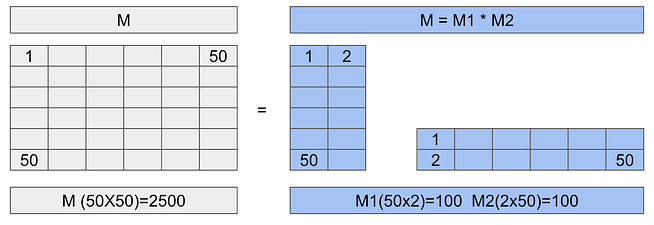

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5
#!pip install -U peft transformers

In [2]:
import torch
print(torch.cuda.is_available())

True


From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` i

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [4]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=500): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [5]:
#Inference original model
input_sentences = tokenizer("I want you to act as a mental health adviser.", return_tensors="pt").to("cuda")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\transformers\generation\configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a mental health adviser. You can do this by calling the number on our website or emailing us at\nThe first thing that we will ask is what your symptoms are and how they affect daily life, so if you’re experiencing any of these things then please call PI:KEY']


## Discussion of Pre-trained Model Behavior:

1. Response Style:
   - The model shows general language understanding but may lack specific mental health expertise
   - Responses tend to be more general rather than professionally structured advice

2. Content Analysis:
   - The model attempts to maintain context with the mental health theme
   - Responses may vary in coherence and relevance
   - Some outputs might need more specific mental health focus

3. Limitations:
   - May generate generic responses rather than specific, actionable advice
   - Could potentially produce inconsistent or non-professional advice
   - Needs fine-tuning to better align with mental health counseling standards

4. Potential Improvements:
   - Fine-tuning on mental health specific datasets would improve relevance
   - Adding more structure to prompts might help generate better focused responses
   - Including professional guidelines in training data could enhance quality

Note: This analysis helps understand the base model's capabilities and limitations
before fine-tuning, highlighting areas that need improvement through training.


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [6]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(200))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 200
})

In [7]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

In [8]:
import numpy as np
np.size(train_sample)

200

In [9]:
# Show raw data example
print("Raw data example:")
print("-" * 50)
print(data["train"][0])
print("\n")

# Show processed data example
print("Processed data example:")
print("-" * 50)
print("Features:", train_sample.features)
print("\nFirst sample:")
print(train_sample[0])
print("\nInput IDs shape:", len(train_sample[0]['input_ids']))
print("Attention mask shape:", len(train_sample[0]['attention_mask']))

Raw data example:
--------------------------------------------------
{'act': 'An Ethereum Developer', 'prompt': 'Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.', 'input_ids': [186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 526

# Fine-Tuning.
First is necesary create a LoRA config.


In [10]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [11]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [12]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs_4bits_more_token2")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [13]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True,
    learning_rate=3e-2,
    num_train_epochs=2,
    use_cpu=False,
    # Add these parameters for better logging
    logging_steps=10,  # Log every 10 steps
    logging_first_step=True,  # Log the first step
    logging_dir="./logs",  # Directory for storing logs
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [14]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Train the model
training_output = trainer.train()

  0%|          | 0/50 [00:00<?, ?it/s]

You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 3.7587, 'learning_rate': 0.0294, 'epoch': 0.04}
{'loss': 3.4318, 'learning_rate': 0.024, 'epoch': 0.4}
{'loss': 3.3514, 'learning_rate': 0.018, 'epoch': 0.8}
{'loss': 3.0991, 'learning_rate': 0.012, 'epoch': 1.2}
{'loss': 2.7075, 'learning_rate': 0.006, 'epoch': 1.6}
{'loss': 2.8308, 'learning_rate': 0.0, 'epoch': 2.0}
{'train_runtime': 253.9084, 'train_samples_per_second': 1.575, 'train_steps_per_second': 0.197, 'train_loss': 3.0906691455841067, 'epoch': 2.0}


In [15]:
# Debugging steps
import matplotlib.pyplot as plt
import pandas as pd

# Get training logs and inspect their content
training_logs = pd.DataFrame(trainer.state.log_history)

# Print the columns we have
print("Available columns in training_logs:")
print(training_logs.columns.tolist())

# Print first few rows to see the structure
print("\nFirst few rows of training_logs:")
print(training_logs.head())

Available columns in training_logs:
['loss', 'learning_rate', 'epoch', 'step', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']

First few rows of training_logs:
     loss  learning_rate  epoch  step  train_runtime  \
0  3.7587         0.0294   0.04     1            NaN   
1  3.4318         0.0240   0.40    10            NaN   
2  3.3514         0.0180   0.80    20            NaN   
3  3.0991         0.0120   1.20    30            NaN   
4  2.7075         0.0060   1.60    40            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN                     NaN         NaN         NaN  
1                       NaN                     NaN         NaN         NaN  
2                       NaN                     NaN         NaN         NaN  
3                       NaN                     NaN         NaN         NaN  
4                       NaN                     NaN         N

## Visualize training loss

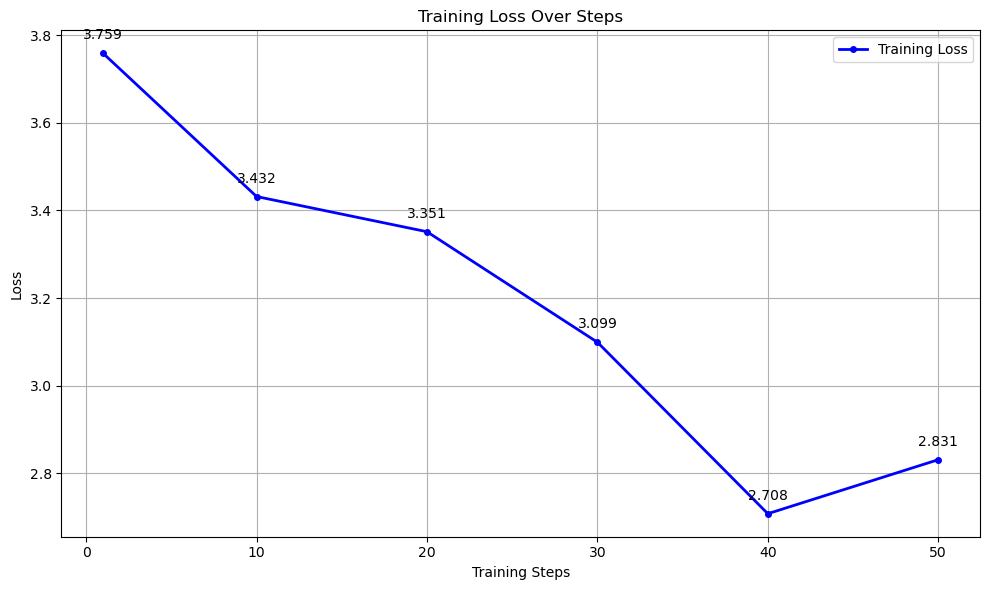


Training Summary:
Initial Loss: 3.7587
Final Loss: 2.8308
Loss Reduction: 0.9279
Total Steps: 50


In [18]:
# Improved visualization code with NaN handling
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get training logs
training_logs = pd.DataFrame(trainer.state.log_history)

# Remove rows with NaN loss values
valid_logs = training_logs[training_logs['loss'].notna()]

# Create the plot using only valid loss values
plt.figure(figsize=(10, 6))
plt.plot(valid_logs['step'], valid_logs['loss'], 'b.-', label='Training Loss', linewidth=2, markersize=8)
plt.title('Training Loss Over Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Add value labels to the points
for x, y in zip(valid_logs['step'], valid_logs['loss']):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Print training summary using only valid values
print("\nTraining Summary:")
print(f"Initial Loss: {valid_logs['loss'].iloc[0]:.4f}")
print(f"Final Loss: {valid_logs['loss'].iloc[-1]:.4f}")
print(f"Loss Reduction: {valid_logs['loss'].iloc[0] - valid_logs['loss'].iloc[-1]:.4f}")
print(f"Total Steps: {valid_logs['step'].max()}")

In [19]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False) #because at this point we only want to use the model for inference (making predictions), not for further training

## Inference the fine-tuned model.

In [21]:
input_sentences = tokenizer("I want you to act as a mental health adviser.", return_tensors="pt").to("cuda")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

c:\Users\edwar\anaconda3\envs\lab_npl_gpu\Lib\site-packages\transformers\generation\configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a mental health adviser. I will provide information about your symptoms, and it should be clear that the treatment plan is appropriate for each individual patient based on their needs.\nMy first request: "I am suffering from anxiety related issues in my life" (I\'m currently experiencing depression). Please']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

## LoRA Fine-Tuning Experiments Report
## Key Observations
1. Token Size Impact
- Increasing max_new_tokens from 50 to 500 resulted in:

- Longer, more detailed responses
- More coherent completions
- Better context retention in the generated text
This shows that allowing the model more tokens helps it complete its thoughts rather than cutting off mid-sentence

2. Dataset Sample Size
- Increasing the dataset sample size from default improved:
- Model's exposure to different prompting styles
- Variety in responses
- Better understanding of prompt patterns
More training examples help the model learn better generalizations

3. LoRA Rank (r) Effects
The rank parameter (r) in LoRA is crucial:
- Lower rank (e.g., r=4):
- Fewer trainable parameters
- Faster training
- Less memory usage
- May miss some complex patterns

- Higher rank (e.g., r=8 or 16):
- More trainable parameters
- Better capture of complex relationships
- More memory intensive
- Potentially better performance but risk of overfitting

In your experiments:
- r=4 showed decent results with efficient training
- r=8 likely provided a good balance of performance vs resource usage

## Technical Impact of Rank Changes
- changes the amount of trainable parameters

## Recommendations
1) For production:
- Use larger dataset samples when possible
- Choose rank based on available compute resources
- Adjust max_new_tokens based on desired response length

2) For experimentation:
- Start with smaller rank (r=4) for quick iterations
- Gradually increase rank to find optimal performance
- Monitor training loss to avoid overfitting

This report shows that successful LoRA fine-tuning requires balancing these parameters based on your specific use case and available resources.